## Imports

In [1]:
%matplotlib inline
import pickle
import urllib
import time
import feedparser
import itertools
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.misc
from tqdm import tqdm
import time
from IPython import display

/Users/michaelfarrell/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #38
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Users/michaelfarrell/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))
/Users/michaelfarrell/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load in data

In [2]:
# Category of papers
category = 'astro-ph'

# Metadata
entries = pickle.load(open(category + '_entries.pkl', 'rb'))
author_ind = pickle.load( open(category + '_author_ind.pkl', 'rb'))

# List of edges in train/test graphs
train_adj_list = pickle.load(open(category + '_train_adj_list.pkl', 'rb'))
test_adj_list = pickle.load(open(category + '_test_adj_list.pkl', 'rb'))

# List of edges with year added in train/test graphs
train_adj_list_w_year = pickle.load( open( category + '_train_adj_list_with_year.pkl'))
test_adj_list_w_year = pickle.load( open( category + '_test_adj_list_with_year.pkl'))

# Number of authors
num_authors = len(author_ind)

# List of author ids
authors = range(num_authors)

# Edges
pos_edges = set([(min(a1, a2), max(a1, a2)) for (a1, a2) in \
                 itertools.combinations(authors, 2)]) - set(train_adj_list)
pred_edges = set(test_adj_list) - set(train_adj_list)

# Years in the training set
train_years = sorted(list(set(map(lambda x : x[2], train_adj_list_w_year))))

# Years in the testing set
test_years = sorted(list(set(map(lambda x : x[2], test_adj_list_w_year))))

# All possible edges
possible_edges = list(itertools.combinations(authors, 2))

## Split the edges up by year

In [3]:
edges_by_year = {}
for year in test_years:
    edges_by_year[year] = map(lambda y: y[:2], filter(lambda x : x[2] == year, test_adj_list_w_year))

In [4]:
for year in test_years:
    year, len(edges_by_year[year])

(1996, 1358)

(1997, 2250)

(1998, 5716)

(1999, 4751)

(2000, 4889)

(2001, 2948)

## Train and validation years

In [5]:
years_for_train = train_years[:3]
valid_year = train_years[3]
'train years', years_for_train, 'validation years', valid_year

('train years', [1996, 1997, 1998], 'validation years', 1999)

## Build the set of edges in the training set

In [6]:
train = set()
for year in years_for_train:
    train = train.union(set(edges_by_year[year]))
n_train = len(train)
n_train

9324

## Label all edges as 1 for edge and 0 for no edge

In [7]:
targets = map(lambda x : int(x in train), possible_edges)
zipped_train_input = zip(possible_edges, targets)

## Validation set of new edges added

In [8]:
valid = set(edges_by_year[valid_year]).difference(train)
n_valid = len(valid)
n_valid

4751

## The set of labled edges to be predicted

In [ ]:
potential_new_edges = set(map(lambda  y : y[0], filter(lambda x: x[1] == 0, zipped_train_input)))
zipped_valid_input = map(lambda x : (x, 1) if x in valid else (x,0), potential_new_edges)
valid_no_edges = filter(lambda x: x[1] == 0, zipped_valid_input)
valid_yes_edges = filter(lambda x: x[1] == 1, zipped_valid_input)

## Matrix Factorization

#### Sigmoid Link, Log Loss, No extrinsic features

EPOCH 7
Avg Train Loss: 0.782653171507
Avg Validation Loss: 0.778104671878
Avg Score for missing edges: 0.0303983133006 Avg Score for added edges: 0.0317043896525
Median Score for missing edges: 0.0300876738178 Media Score for added edges: 0.0310306960923
Avg Difference: 0.00130607635188
Median Difference: 0.000943022274511
Accuracy on Top 4751 : 0.0130498842349


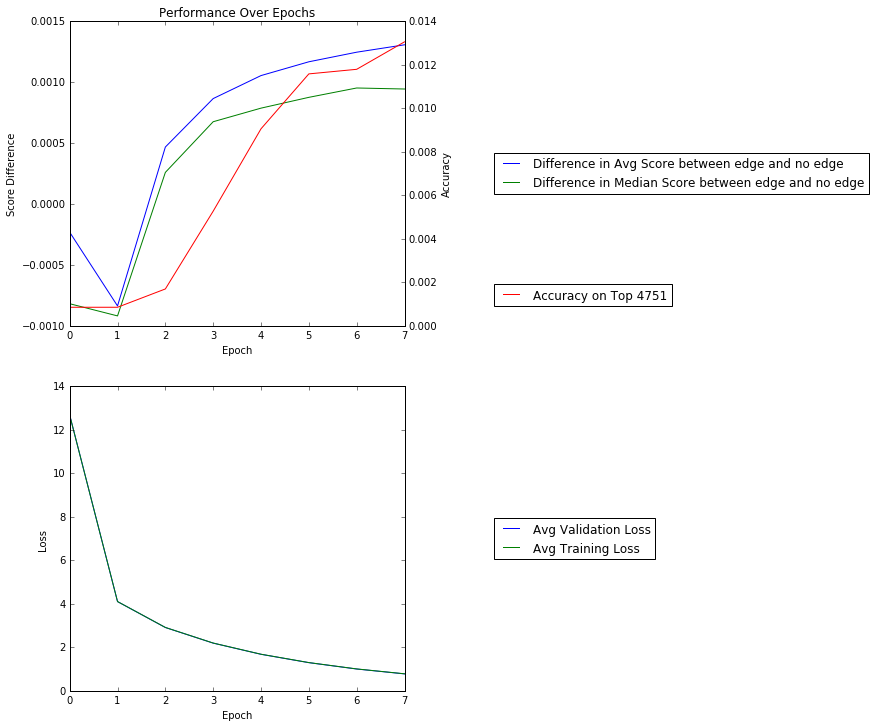

  4%|▎         | 118669/3272961 [00:02<01:02, 50251.66it/s]

In [ ]:
k = 10 # Number of latent features
gammaU = 1e-3 # Learning rate for latent feature vectors
gammaB = 1e-3 # Learning rate for node biases
lambdaU = 1e-1 # regularization parameter for latent feature vecotrs
TOP_K = n_valid # K to use for top k accuracy
N_EPOCH = 25 # Number of epochs to train
link = lambda x : 1 / (1 + np.exp(-x)) # the link function mapping score to prediction
loss = lambda (p, t): -t * np.log(p) - (1-t) * np.log(1-p) # loss function takes in prediction and target and returns loss
score = lambda i, j: np.dot(U[i], U[j]) + B[i] + B[j] # Takes in two nodes and scores their probability of an edge

###################################################################################################

U = np.random.rand(num_authors,k) # latent feature matrix
B = np.random.rand(num_authors) # Biases

# Holding the train/validation losses
train_losses = []
valid_losses = []

# Holds the average/medians prediction score for edges being added and not added
no_avgs = []
no_meds = []
yes_avgs = []
yes_meds = []

# Differences between yes_avgs and no_avgs, yes_meds and no_meds
diff_avgs = []
diff_meds = []

# Accuracy on TOP_K
topk_acc = []


def predict(vals):
    '''
        Give the zipped input, returned the prediction and target value in a 
        list of tuples
        
        (pred, targ)
    '''
    return map(lambda ((i,j), t) : (link(score(i, j)), t), vals)

def calc_loss(vals):
    '''
        Return the loss for the current state 
    '''
    # Regularizer
    reg_term = lambdaU * np.linalg.norm(U, ord='fro')
    
    # Make predictions
    preds = predict(vals)
    
    # Calculate loss with regularization
    return np.mean(map(loss, preds)) + reg_term

def top_acc(vals):
    '''
        Determine our TOP_K rated edges and see if they are in the set
        of edges that were added in the validations et
    '''
    predictions = predict(vals)
    
    # Sort predictions 
    sorted_scores = sorted(predictions, key= lambda  x: x[0], reverse=True)
    
    # Sett how many of the top predictions have an edge
    return len(filter(lambda x : x[1] == 1, sorted_scores[:TOP_K])) / float(TOP_K)

def print_status(epoch):
    '''
        Prints the current status of the SGD operation
    '''
    print 'EPOCH', epoch

    train_losses.append(calc_loss(zipped_train_input))
    print 'Avg Train Loss:',train_losses[epoch]

    valid_losses.append(calc_loss(zipped_valid_input))
    print 'Avg Validation Loss:', valid_losses[epoch]
    
    no_preds =  map(lambda x : x[0], predict(valid_no_edges))
    no_avgs.append(np.mean(no_preds))
    no_meds.append(np.median(no_preds))
    
    yes_preds = map(lambda x : x[0],predict(valid_yes_edges))
    yes_avgs.append(np.mean(yes_preds))
    yes_meds.append(np.median(yes_preds))
    print 'Avg Score for missing edges:', no_avgs[epoch], 'Avg Score for added edges:', yes_avgs[epoch]
    print 'Median Score for missing edges:', no_meds[epoch], 'Media Score for added edges:', yes_meds[epoch]

    diff_avgs.append(yes_avgs[epoch] - no_avgs[epoch])
    print 'Avg Difference:', diff_avgs[epoch]
    
    diff_meds.append(yes_meds[epoch] - no_meds[epoch])
    print 'Median Difference:', diff_meds[epoch]

    topk_acc.append(top_acc(zipped_valid_input))
    print 'Accuracy on Top', TOP_K, ':', topk_acc[epoch]

def plot_results(epoch):
    '''
        Plots the results vs the epochs
    '''
    fig, ax = plt.subplots(2,1, figsize = (6,12))
    
    # PLot score differential
    _ = ax[0].plot(range(epoch + 1), diff_avgs, label = 'Difference in Avg Score between edge and no edge')
    _ = ax[0].plot(range(epoch + 1), diff_meds, label = 'Difference in Median Score between edge and no edge')
    _ = ax[0].set_title('Performance Over Epochs')
    _ = ax[0].set_xlabel('Epoch')
    _ = ax[0].set_ylabel('Score Difference')
    
    # On same plot plot accuracy on top k
    ax2 = ax[0].twinx()
    _ = ax2.plot(range(epoch + 1), topk_acc, 'r', label = 'Accuracy on Top %s' % TOP_K)
    _ = ax2.set_ylabel('Accuracy')
    _ = ax2.legend(loc='center left', bbox_to_anchor=(1.25, 0.1))
    _ = ax[0].legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
    
    # On second plot plot loss
    _ = ax[1].plot(range(epoch + 1), valid_losses, label = 'Avg Validation Loss')
    _ = ax[1].plot(range(epoch + 1), train_losses, label = 'Avg Training Loss')
    _ = ax[1].set_xlabel('Epoch')
    _ = ax[1].set_ylabel('Loss')
    _ = ax[1].legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
    
print_status(0)

# SGD
for epoch in range(1, N_EPOCH+1):

    # Shuffle the training values
    np.random.shuffle(zipped_train_input)
    
    # Iterate through possible edges and update parameters
    for (i,j), target in tqdm(zipped_train_input):
        
        sij = np.exp(score(i,j))
        eij = -((target - 1)*sij + target) / (1+sij)
        U[i] -= gammaU*(eij*U[j] + lambdaU*U[i])
        U[j] -= gammaU*(eij*U[i] + lambdaU*U[j])
        B[i] -= gammaB*eij
        B[j] -= gammaB*eij
    
    # Clear the display
    display.clear_output(wait=True)
    time.sleep(1)
    
    # Print out the results of the epoch
    print_status(epoch)
    
    # Plot and saves results
    plot_results(epoch)
    
    # Display plot
    display.display(plt.gcf())
